In [1]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [2]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [3]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [4]:
data_copy = king_all_copy
print(data_copy['date'])
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

0       1939-01-01
1       1939-01-02
2       1939-01-03
3       1939-01-04
4       1939-01-05
           ...    
24364   2020-12-25
24365   2020-12-26
24366   2020-12-27
24367   2020-12-28
24368   2020-12-29
Name: date, Length: 24369, dtype: datetime64[ns]


,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [5]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [6]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [7]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [8]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [9]:
master_data = master_data[132:]

In [10]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [11]:
master_data.reset_index(inplace=True)

In [12]:
master_data = master_data.drop(labels='index', axis=1)

In [13]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


<h2>Load Covariate Data and Concat to Master_Data</h2>

In [14]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [15]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
chris_path_cov = '/Users/chrisshell/Desktop/Stanford/SalmonData/Environmental Variables/salmon_env_use.csv'
abdul_path_cov= '/Users/abdul/Downloads/SalmonNet/salmon_env_use.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [16]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [17]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [18]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [19]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [20]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [21]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


<h2> Load and Concat NOI data </h2>

In [22]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [23]:
master_data.to_csv('master_data.csv')

In [24]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
chris_checkpoint_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Checkpoint'
abdul_checkpoint_path = '/Users/abdul/Downloads/SalmonNet/Checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

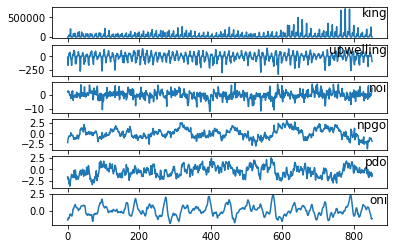

In [25]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [26]:
# convert series to supervised learning
# series_to_supervised from Jason Brownlee's "Multivariate Time Series Forecasting in Keras"
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [27]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [28]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [29]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/1000
8/8 - 3s - loss: 0.1804 - root_mean_squared_error: 0.4248 - val_loss: 0.0968 - val_root_mean_squared_error: 0.3112
Epoch 2/1000
8/8 - 0s - loss: 0.0573 - root_mean_squared_error: 0.2393 - val_loss: 0.0604 - val_root_mean_squared_error: 0.2458
Epoch 3/1000
8/8 - 0s - loss: 0.0301 - root_mean_squared_error: 0.1735 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2157
Epoch 4/1000
8/8 - 0s - loss: 0.0312 - root_mean_squared_error: 0.1766 - val_loss: 0.0410 - val_root_mean_squared_error: 0.2026
Epoch 5/1000
8/8 - 0s - loss: 0.0294 - root_mean_squared_error: 0.1716 - val_loss: 0.0630 - val_root_mean_squared_error: 0.2509
Epoch 6/1000
8/8 - 0s - loss: 0.0198 - root_mean_squared_error: 0.1406 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2401
Epoch 7/1000
8/8 - 0s - loss: 0.0129 - root_mean_squared_error: 0.1137 - val_loss: 0.0384 - val_root_mean_squared_error: 0.1959
Epoch 8/1000
8/8 - 0s - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0337 - val_root_mea

Epoch 40/1000
8/8 - 0s - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1773
Epoch 41/1000
8/8 - 0s - loss: 0.0083 - root_mean_squared_error: 0.0910 - val_loss: 0.0318 - val_root_mean_squared_error: 0.1785
Epoch 42/1000
8/8 - 0s - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0319 - val_root_mean_squared_error: 0.1787
Epoch 43/1000
8/8 - 0s - loss: 0.0076 - root_mean_squared_error: 0.0873 - val_loss: 0.0316 - val_root_mean_squared_error: 0.1778
Epoch 44/1000
8/8 - 0s - loss: 0.0073 - root_mean_squared_error: 0.0854 - val_loss: 0.0310 - val_root_mean_squared_error: 0.1762
Epoch 45/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0842 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1745
Epoch 46/1000
8/8 - 0s - loss: 0.0070 - root_mean_squared_error: 0.0840 - val_loss: 0.0300 - val_root_mean_squared_error: 0.1733
Epoch 47/1000
8/8 - 0s - loss: 0.0071 - root_mean_squared_error: 0.0846 - val_loss: 0.0298 - val_

Epoch 79/1000
8/8 - 0s - loss: 0.0068 - root_mean_squared_error: 0.0826 - val_loss: 0.0277 - val_root_mean_squared_error: 0.1663
Epoch 80/1000
8/8 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0821 - val_loss: 0.0276 - val_root_mean_squared_error: 0.1660
Epoch 81/1000
8/8 - 0s - loss: 0.0067 - root_mean_squared_error: 0.0816 - val_loss: 0.0274 - val_root_mean_squared_error: 0.1656
Epoch 82/1000
8/8 - 0s - loss: 0.0066 - root_mean_squared_error: 0.0812 - val_loss: 0.0272 - val_root_mean_squared_error: 0.1651
Epoch 83/1000
8/8 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1645
Epoch 84/1000
8/8 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0269 - val_root_mean_squared_error: 0.1640
Epoch 85/1000
8/8 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 0.0267 - val_root_mean_squared_error: 0.1635
Epoch 86/1000
8/8 - 0s - loss: 0.0065 - root_mean_squared_error: 0.0808 - val_loss: 0.0266 - val_

Epoch 118/1000
8/8 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0746 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1541
Epoch 119/1000
8/8 - 0s - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1530
Epoch 120/1000
8/8 - 0s - loss: 0.0055 - root_mean_squared_error: 0.0741 - val_loss: 0.0231 - val_root_mean_squared_error: 0.1520
Epoch 121/1000
8/8 - 0s - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 122/1000
8/8 - 0s - loss: 0.0056 - root_mean_squared_error: 0.0748 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1503
Epoch 123/1000
8/8 - 0s - loss: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1497
Epoch 124/1000
8/8 - 0s - loss: 0.0059 - root_mean_squared_error: 0.0765 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 125/1000
8/8 - 0s - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.022

Epoch 157/1000
8/8 - 0s - loss: 0.0062 - root_mean_squared_error: 0.0790 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1411
Epoch 158/1000
8/8 - 0s - loss: 0.0062 - root_mean_squared_error: 0.0785 - val_loss: 0.0209 - val_root_mean_squared_error: 0.1445
Epoch 159/1000
8/8 - 0s - loss: 0.0058 - root_mean_squared_error: 0.0760 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1479
Epoch 160/1000
8/8 - 0s - loss: 0.0054 - root_mean_squared_error: 0.0733 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 161/1000
8/8 - 0s - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1477
Epoch 162/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1440
Epoch 163/1000
8/8 - 0s - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1398
Epoch 164/1000
8/8 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0664 - val_loss: 0.018

Epoch 196/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0703 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1271
Epoch 197/1000
8/8 - 0s - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0165 - val_root_mean_squared_error: 0.1283
Epoch 198/1000
8/8 - 0s - loss: 0.0047 - root_mean_squared_error: 0.0685 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1299
Epoch 199/1000
8/8 - 0s - loss: 0.0044 - root_mean_squared_error: 0.0665 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1316
Epoch 200/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0651 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 201/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0175 - val_root_mean_squared_error: 0.1322
Epoch 202/1000
8/8 - 0s - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1303
Epoch 203/1000
8/8 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.016

Epoch 235/1000
8/8 - 0s - loss: 0.0039 - root_mean_squared_error: 0.0623 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 236/1000
8/8 - 0s - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 237/1000
8/8 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1143
Epoch 238/1000
8/8 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 239/1000
8/8 - 0s - loss: 0.0035 - root_mean_squared_error: 0.0589 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 240/1000
8/8 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0581 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 241/1000
8/8 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 242/1000
8/8 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.012

Epoch 274/1000
8/8 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0605 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 275/1000
8/8 - 0s - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 276/1000
8/8 - 0s - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 277/1000
8/8 - 0s - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 278/1000
8/8 - 0s - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 279/1000
8/8 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1034
Epoch 280/1000
8/8 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1031
Epoch 281/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.010

Epoch 313/1000
8/8 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0928
Epoch 314/1000
8/8 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 315/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 316/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 317/1000
8/8 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0488 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 318/1000
8/8 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 319/1000
8/8 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 320/1000
8/8 - 0s - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.008

Epoch 352/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0827
Epoch 353/1000
8/8 - 0s - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 354/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0830
Epoch 355/1000
8/8 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0534 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0833
Epoch 356/1000
8/8 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 357/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0877
Epoch 358/1000
8/8 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0909
Epoch 359/1000
8/8 - 0s - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.008

Epoch 391/1000
8/8 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 392/1000
8/8 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 393/1000
8/8 - 0s - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 394/1000
8/8 - 0s - loss: 0.0022 - root_mean_squared_error: 0.0467 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 395/1000
8/8 - 0s - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0773
Epoch 396/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0840
Epoch 397/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0853
Epoch 398/1000
8/8 - 0s - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.006

Epoch 430/1000
8/8 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 431/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0399 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 432/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0729
Epoch 433/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0725
Epoch 434/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0713
Epoch 435/1000
8/8 - 0s - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 436/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0755
Epoch 437/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.005

Epoch 469/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0682
Epoch 470/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 471/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 472/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0652
Epoch 473/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0357 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0657
Epoch 474/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 475/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0362 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0653
Epoch 476/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.004

Epoch 508/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 509/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0338 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 510/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0350 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 511/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 512/1000
8/8 - 0s - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 513/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 514/1000
8/8 - 0s - loss: 0.0016 - root_mean_squared_error: 0.0396 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
Epoch 515/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.003

Epoch 547/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 548/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 549/1000
8/8 - 0s - loss: 9.9062e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0543
Epoch 550/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0545
Epoch 551/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 552/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 553/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 554/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0

8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 586/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 587/1000
8/8 - 0s - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0545
Epoch 588/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0506
Epoch 589/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 590/1000
8/8 - 0s - loss: 9.9169e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 591/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 592/1000
8/8 - 0s - loss: 8.5596e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0029 - val

Epoch 624/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 625/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 626/1000
8/8 - 0s - loss: 8.9907e-04 - root_mean_squared_error: 0.0300 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 627/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 628/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0505
Epoch 629/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 630/1000
8/8 - 0s - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 631/1000
8/8 - 0s - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0

Epoch 662/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0346 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 663/1000
8/8 - 0s - loss: 9.2852e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 664/1000
8/8 - 0s - loss: 0.0011 - root_mean_squared_error: 0.0325 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 665/1000
8/8 - 0s - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 666/1000
8/8 - 0s - loss: 8.4643e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0503
Epoch 667/1000
8/8 - 0s - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0453
Epoch 668/1000
8/8 - 0s - loss: 8.3200e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 669/1000
8/8 - 0s - loss: 6.3169e-04 - root_mean_squared_error: 0.0251 -

Epoch 700/1000
8/8 - 0s - loss: 7.7608e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0418
Epoch 701/1000
8/8 - 0s - loss: 8.3258e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 702/1000
8/8 - 0s - loss: 7.2847e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 703/1000
8/8 - 0s - loss: 6.4246e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 704/1000
8/8 - 0s - loss: 9.8904e-04 - root_mean_squared_error: 0.0314 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 705/1000
8/8 - 0s - loss: 5.5888e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0381
Epoch 706/1000
8/8 - 0s - loss: 5.4454e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 707/1000
8/8 - 0s - loss: 6.6511e-04 - root_mean_squared

Epoch 738/1000
8/8 - 0s - loss: 8.0024e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 739/1000
8/8 - 0s - loss: 8.2579e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 740/1000
8/8 - 0s - loss: 8.0339e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 741/1000
8/8 - 0s - loss: 6.3630e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 742/1000
8/8 - 0s - loss: 6.1048e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 743/1000
8/8 - 0s - loss: 8.0150e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 744/1000
8/8 - 0s - loss: 7.0910e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 745/1000
8/8 - 0s - loss: 7.2883e-04 - root_mean_squared

Epoch 776/1000
8/8 - 0s - loss: 5.5797e-04 - root_mean_squared_error: 0.0236 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 777/1000
8/8 - 0s - loss: 5.3626e-04 - root_mean_squared_error: 0.0232 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 778/1000
8/8 - 0s - loss: 5.0608e-04 - root_mean_squared_error: 0.0225 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 779/1000
8/8 - 0s - loss: 6.9473e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 780/1000
8/8 - 0s - loss: 5.3221e-04 - root_mean_squared_error: 0.0231 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 781/1000
8/8 - 0s - loss: 5.8925e-04 - root_mean_squared_error: 0.0243 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 782/1000
8/8 - 0s - loss: 7.6191e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 783/1000
8/8 - 0s - loss: 6.7035e-04 - root_mean_squared

Epoch 814/1000
8/8 - 0s - loss: 8.3650e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 815/1000
8/8 - 0s - loss: 8.4868e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 816/1000
8/8 - 0s - loss: 6.3198e-04 - root_mean_squared_error: 0.0251 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 817/1000
8/8 - 0s - loss: 5.8687e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 818/1000
8/8 - 0s - loss: 7.3861e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 819/1000
8/8 - 0s - loss: 4.9231e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 820/1000
8/8 - 0s - loss: 6.7916e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 821/1000
8/8 - 0s - loss: 7.3542e-04 - root_mean_squared

Epoch 852/1000
8/8 - 0s - loss: 4.3778e-04 - root_mean_squared_error: 0.0209 - val_loss: 9.0995e-04 - val_root_mean_squared_error: 0.0302
Epoch 853/1000
8/8 - 0s - loss: 4.7170e-04 - root_mean_squared_error: 0.0217 - val_loss: 9.7871e-04 - val_root_mean_squared_error: 0.0313
Epoch 854/1000
8/8 - 0s - loss: 4.2918e-04 - root_mean_squared_error: 0.0207 - val_loss: 9.1141e-04 - val_root_mean_squared_error: 0.0302
Epoch 855/1000
8/8 - 0s - loss: 4.9944e-04 - root_mean_squared_error: 0.0223 - val_loss: 8.7434e-04 - val_root_mean_squared_error: 0.0296
Epoch 856/1000
8/8 - 0s - loss: 4.3915e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 857/1000
8/8 - 0s - loss: 5.2614e-04 - root_mean_squared_error: 0.0229 - val_loss: 7.9903e-04 - val_root_mean_squared_error: 0.0283
Epoch 858/1000
8/8 - 0s - loss: 5.0553e-04 - root_mean_squared_error: 0.0225 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 859/1000
8/8 - 0s - loss: 5.2350e-04

Epoch 890/1000
8/8 - 0s - loss: 4.6841e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.6541e-04 - val_root_mean_squared_error: 0.0294
Epoch 891/1000
8/8 - 0s - loss: 3.6153e-04 - root_mean_squared_error: 0.0190 - val_loss: 9.0860e-04 - val_root_mean_squared_error: 0.0301
Epoch 892/1000
8/8 - 0s - loss: 5.2558e-04 - root_mean_squared_error: 0.0229 - val_loss: 7.5420e-04 - val_root_mean_squared_error: 0.0275
Epoch 893/1000
8/8 - 0s - loss: 4.8337e-04 - root_mean_squared_error: 0.0220 - val_loss: 9.4404e-04 - val_root_mean_squared_error: 0.0307
Epoch 894/1000
8/8 - 0s - loss: 4.5927e-04 - root_mean_squared_error: 0.0214 - val_loss: 7.7305e-04 - val_root_mean_squared_error: 0.0278
Epoch 895/1000
8/8 - 0s - loss: 5.0648e-04 - root_mean_squared_error: 0.0225 - val_loss: 8.6223e-04 - val_root_mean_squared_error: 0.0294
Epoch 896/1000
8/8 - 0s - loss: 4.8759e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 897/1000
8/8 - 0s - loss: 7.8271

Epoch 927/1000
8/8 - 0s - loss: 5.0677e-04 - root_mean_squared_error: 0.0225 - val_loss: 9.5029e-04 - val_root_mean_squared_error: 0.0308
Epoch 928/1000
8/8 - 0s - loss: 4.5818e-04 - root_mean_squared_error: 0.0214 - val_loss: 7.3219e-04 - val_root_mean_squared_error: 0.0271
Epoch 929/1000
8/8 - 0s - loss: 4.8201e-04 - root_mean_squared_error: 0.0220 - val_loss: 7.6715e-04 - val_root_mean_squared_error: 0.0277
Epoch 930/1000
8/8 - 0s - loss: 4.4065e-04 - root_mean_squared_error: 0.0210 - val_loss: 9.1801e-04 - val_root_mean_squared_error: 0.0303
Epoch 931/1000
8/8 - 0s - loss: 6.3190e-04 - root_mean_squared_error: 0.0251 - val_loss: 6.6803e-04 - val_root_mean_squared_error: 0.0258
Epoch 932/1000
8/8 - 0s - loss: 4.7593e-04 - root_mean_squared_error: 0.0218 - val_loss: 8.5854e-04 - val_root_mean_squared_error: 0.0293
Epoch 933/1000
8/8 - 0s - loss: 4.8801e-04 - root_mean_squared_error: 0.0221 - val_loss: 6.5830e-04 - val_root_mean_squared_error: 0.0257
Epoch 934/1000
8/8 - 0s - loss: 4.

Epoch 965/1000
8/8 - 0s - loss: 7.0407e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 966/1000
8/8 - 0s - loss: 7.5009e-04 - root_mean_squared_error: 0.0274 - val_loss: 8.1880e-04 - val_root_mean_squared_error: 0.0286
Epoch 967/1000
8/8 - 0s - loss: 7.4476e-04 - root_mean_squared_error: 0.0273 - val_loss: 9.8662e-04 - val_root_mean_squared_error: 0.0314
Epoch 968/1000
8/8 - 0s - loss: 5.3592e-04 - root_mean_squared_error: 0.0231 - val_loss: 9.4878e-04 - val_root_mean_squared_error: 0.0308
Epoch 969/1000
8/8 - 0s - loss: 5.5794e-04 - root_mean_squared_error: 0.0236 - val_loss: 6.4221e-04 - val_root_mean_squared_error: 0.0253
Epoch 970/1000
8/8 - 0s - loss: 4.6733e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.2506e-04 - val_root_mean_squared_error: 0.0287
Epoch 971/1000
8/8 - 0s - loss: 4.8464e-04 - root_mean_squared_error: 0.0220 - val_loss: 6.1459e-04 - val_root_mean_squared_error: 0.0248
Epoch 972/1000
8/8 - 0s - loss: 5.3340

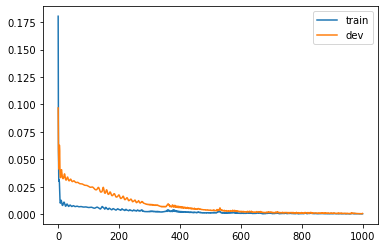

In [30]:
# design network
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(50, return_sequences=True))
model.add(SimpleRNN(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=100, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [31]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [32]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [33]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [34]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The test root mean squared error is {}.".format(rmse))

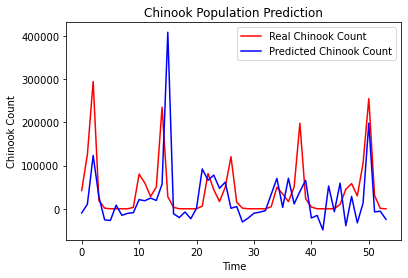

The test root mean squared error is 77593.65912237932.


In [35]:
plot_predictions(inv_y, inv_yhat)
return_rmse(inv_y, inv_yhat)

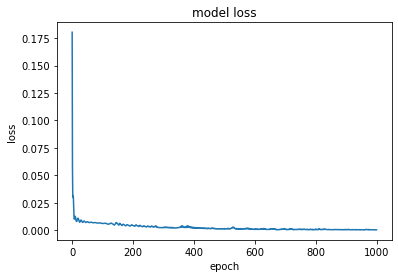

In [36]:
plot_loss(history)

In [37]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  491731
1  270690
2  235554
3  187220
    Count
0  488981
1  336030
2  381773
3  535746


In [38]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [39]:
return_rmse(actual, traditional)

The test root mean squared error is 115829.72216361394.


In [40]:
return_rmse(actual, preds)

The test root mean squared error is 191785.84849839678.
